#Stell Temperature Prediction


**Current problem:**

In order to optimize production costs, the metallurgical plant Temper Steel LLC decided to reduce electricity consumption at the stage of steel processing. It is necessary to build a model that will predict the outlet temperature of the steel. Thus, it is planned to solve the problem of overheating and, accordingly, excessive consumption of electricity.

### Description of data

The data consists of files obtained from different sources:

- `data_arc.csv` — electrode data;
- `data_bulk.csv` - data on the supply of bulk materials (volume);
- `data_bulk_time.csv` *—* data on the supply of bulk materials (time);
- `data_gas.csv` — data on alloy gas purge;
- `data_temp.csv` - temperature measurement results;
- `data_wire.csv` - data on wire materials (volume);
- `data_wire_time.csv` - data on wire materials (time).

In all files, the `key` column contains the batch number. There can be several lines in files with the same `key` value: they correspond to different processing iterations.

### To be done:

- Loading libraries, classes and data;
- EDA
- Data preprocessing based on information from EDA;
- Select the necessary features for modeling;
- Combine data on batches of steel;
- Train several models: CatBoost, LightGBM, LinearRegression, select the best hyperparameters using GridSearchCV;
- Choose the best model;
- Define feature importance to understand which features have the greatest impact on the outlet temperature;
- Prepare conclusions and recommendations.

## EDA

Importing libraries.

In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost
import lightgbm as lgbm
from catboost import CatBoostRegressor, Pool, cv
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Downloading data:

In [ ]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

Creating a function to display analytical information on the dataset:

In [ ]:
def analysis(df):
    display(df.head(6))
    display(df.info())
    display(df.describe())
    display("Number of duplicate lines:", df.duplicated().sum())

Let's create a function for drawing analytical graphs (histogram and boxplot):

In [ ]:
def plot_hist_boxplot(column, name):
    fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(14,6))
    ax[0].hist(column[name], bins=30, density=True, rwidth=0.9, alpha=0.5)
    ax[1].boxplot(column[name], vert=False)
    fig.suptitle(f'Distribution of field values "{name}"', fontsize=16)
    ax[1].set_xlabel(f'{name}', fontsize=10)
    ax[0].grid(color='gray', linestyle='dashed', alpha=0.3)
    ax[1].grid()

### Electrode data (data_arc)

In [ ]:
analysis(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


'Количество задублированных строк:'

0

The electrode information table (data_arc) contains 14876 rows, with no missing values or duplicated rows. It is necessary to change the data type in the fields "Arc heating start" and "Arc heating end" to **datetime**.

There is an anomaly in the "Reactive power" field, it is necessary to check for outliers.

<br>
Replacing the data type <b>object</b> with <b>datetime</b>.

In [ ]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

Count the number of unique batches.

In [ ]:
len(data_arc['key'].unique())

3214

The data contains information on 3214 unique batches.

<br>
Let's look at the distribution of the feature "Active power".

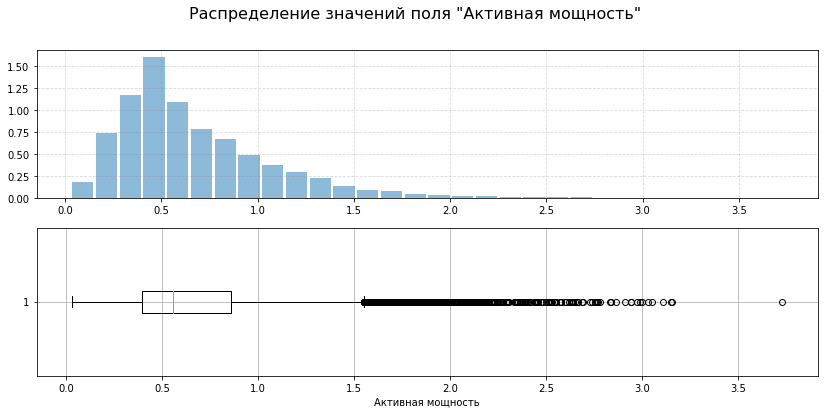

In [ ]:
plot_hist_boxplot(data_arc, 'Активная мощность')

The data in the field "Active power" are normally distributed with a shift to the left. No significant outliers are observed.

<br>
Let's look at the distribution of the feature "Reactive power".

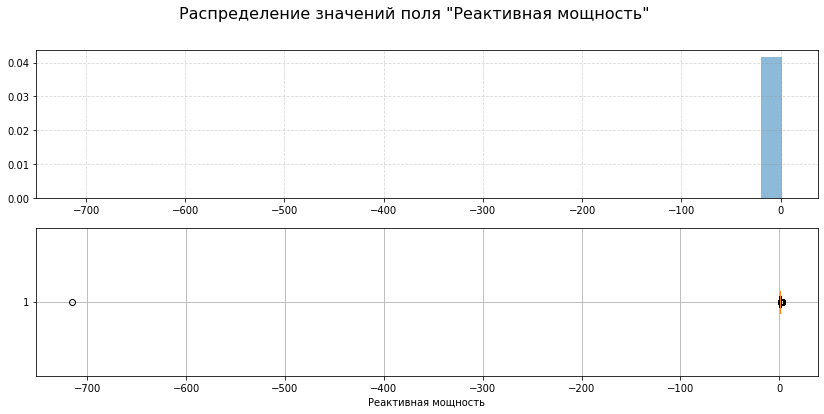

In [ ]:
plot_hist_boxplot(data_arc, 'Реактивная мощность')

In [ ]:
(data_arc['Реактивная мощность'] < 0).sum()

1

One outlier with a value less than zero was found in the data, we remove it and re-evaluate the distribution.

In [ ]:
data_arc = data_arc[data_arc['Реактивная мощность'] >= 0]

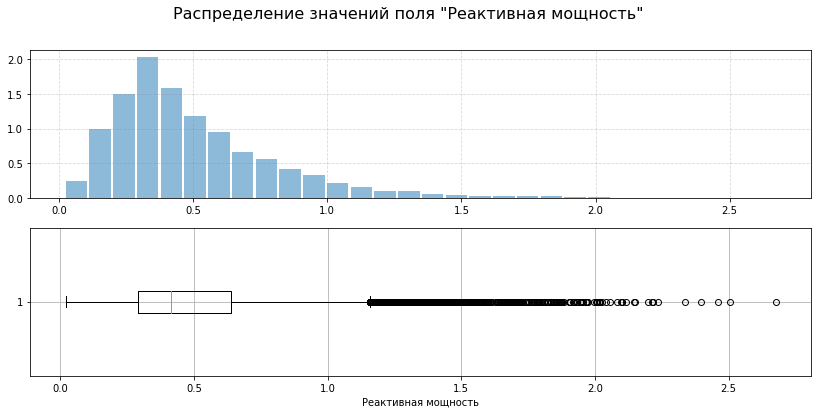

In [ ]:
plot_hist_boxplot(data_arc, 'Реактивная мощность')

Let's check the correlation of these features.

In [ ]:
data_arc['Активная мощность'].corr(data_arc['Реактивная мощность'])

0.9631819131519803

The correlation between features is high. We can convert two features into one, based on a formula from physics:
$$ S = {\sqrt{P^2 + Q^2}} $$
where **P** is active power, **Q** is reactive power

Let's add a new attribute **"Full power"**.

In [ ]:
def full_power(row):
    full_power = math.sqrt(row['Активная мощность']**2 + row['Реактивная мощность']**2)
    return full_power

In [ ]:
data_arc['Полная мощность'] = data_arc.apply(full_power, axis=1)

**Analysis results**: examined the electrode data, corrected the data types and got rid of the outlier in the **"Reactive Power"** field. We checked the data correlation, added a new sign **"Full power"**. Extra features will be removed at the stage of data preparation.

### Bulk material supply data (volume) (data_bulk)

In [ ]:
analysis(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


'Количество задублированных строк:'

0

**Analytical results**: Bulk volume data contains many gaps as a different combination of materials was used for each lot. Therefore, we will not do anything with passes.

### Bulk material data (time) (data_bulk_time)

In [ ]:
data_bulk_time.head(3)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40


**Analysis Results**: Bulk material feed time information will not be used in model building.

### Alloy gas purge data (data_gas)

In [ ]:
analysis(data_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


'Количество задублированных строк:'

0

Data distribution:

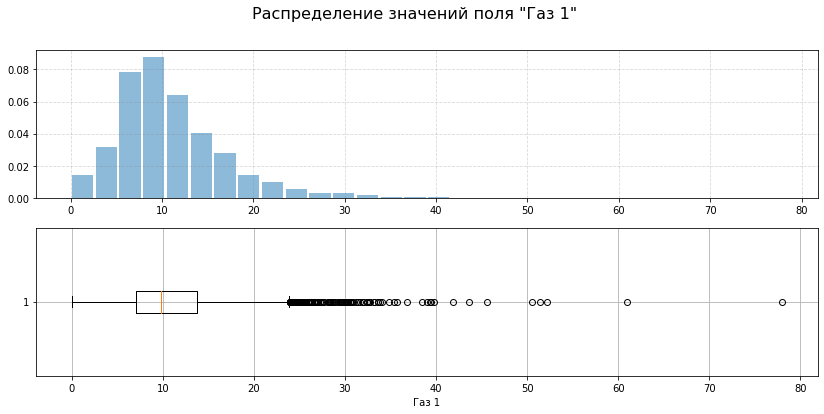

In [ ]:
plot_hist_boxplot(data_gas, "Газ 1")

**Analysis results**: Gas purge data distribution is normal, skewed to the left. There are anomalous high values, but they cannot be attributed to outliers, as this could be part of the manufacturing process for a particular batch. There are no gaps or duplicates in the data.

### Temperature measurement results (data_temp)

In [ ]:
analysis(data_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


'Количество задублированных строк:'

0

The temperature information table (data_temp) contains 15907 rows, with no duplicated rows. Some lines have missing values, temperature is not specified. It is necessary to change the data type in the field "Sampling time" **datetime**.

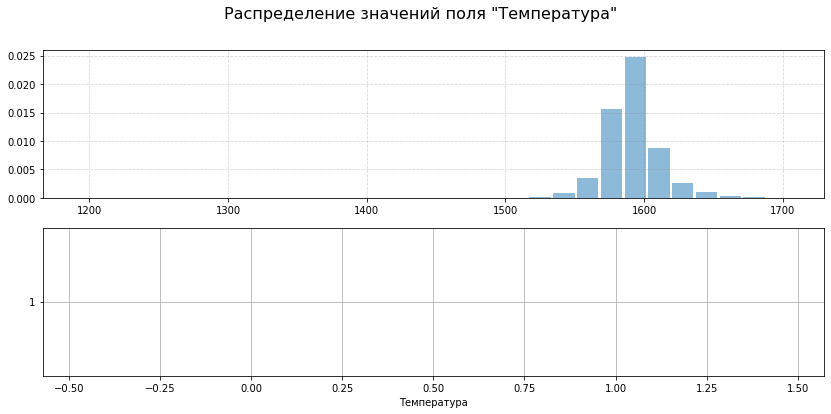

In [ ]:
plot_hist_boxplot(data_temp, "Температура")

In [ ]:
data_temp[data_temp['Температура'].isnull()].head(5)

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN


Starting from batch 2500, there is no temperature. Let's check if this is so.

In [ ]:
data_temp[(data_temp['Температура'].notnull()) & (data_temp['key'] >= 2500)].count()

key             739
Время замера    739
Температура     739
dtype: int64

**Analysis results**: the correct data type was determined for the "Sampling time" field, <b>object</b> was replaced by <b>datetime</b>. From batch 2500 no temperature data is available. Batch data will not be used when building models. Data distribution appears to be normal, with no significant anomalies, most (75%) < 1601°C. There are no duplicated lines.

### Wire materials data (volume) (data_wire)

In [ ]:
analysis(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


'Количество задублированных строк:'

0

**Analysis results**: similar situation with bulk materials, many gaps, since each batch requires its own set of wire materials.

### Wire materials data (time) (data_wire_time)

In [ ]:
data_wire_time.head(3)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Analysis Results**: Information about the time of feeding wire materials will not be used in the construction of models.

### EDA Results:

- Downloaded and explored all datasets;
- Defined extra data (data_bulk_time, data_wire_time)
- Corrected data types;
- Made a decision to work with missing values in each dataset;
- We studied data distributions and got rid of one outlier (Electrode data, "Reactive energy" field)

## Data preparation

**To be done:**

**Electrode data.**
- Get rid of the heating time data in datetime format by converting this information into a scalar value (seconds);
- For each batch there was a different number of heating iterations, this is valuable information that we will add as a new feature;
- Remove the correlating features (Section 2.1) "Reactive power" and "Active power" from the data on the electrodes;

**Temperature data.**
- Remove objects without a target feature (clause 2.6 - all batches up to No. 2499);
- Remove objects where there was only one temperature measurement;
- Extract the temperature at the inlet and outlet from the data.

**Combining data and preparing features.**
- Combine data on batches of steel;
- Divide the data into training and test sets;
Let's do the scaling.

### Electrode data

Adding a new attribute **"Heating time"** and removing unnecessary attributes with dates.

In [ ]:
data_arc['Время нагрева'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.seconds

In [ ]:
data_arc.drop(['Начало нагрева дугой', 'Конец нагрева дугой'], axis=1, inplace=True)

Creation of a new feature **"Number of iterations"**, but it will be added only after grouping by batches.

In [ ]:
data_arc_сopy = data_arc.groupby(by = 'key', as_index = False).count()[['key', 'Время нагрева']]
data_arc_сopy.columns = ['key', 'Количество итераций']

Removing correlated features:

In [ ]:
data_arc.drop(['Активная мощность', 'Реактивная мощность'], axis=1, inplace=True)

Grouping of electrode data by batch number.

Adding the feature "Number of iterations to the final table by electrodes.

In [ ]:
data_arc = data_arc.merge(data_arc_сopy, on = 'key')

Checking the correlation of features after all manipulations:

In [ ]:
data_arc[['Полная мощность', 'Время нагрева', 'Количество итераций']].corr()

,Полная мощность,Время нагрева,Количество итераций
Полная мощность,1.000000,0.981205,-0.025770
Время нагрева,0.981205,1.000000,-0.035763
Количество итераций,-0.025770,-0.035763,1.000000


The correlation between full power and heating time is very high. Thus, we are forced to get rid of the feature "Heating time".

In [ ]:
data_arc.drop('Время нагрева', axis=1, inplace=True)

Grouping data by batches of steel.

In [ ]:
data_arc = data_arc.groupby(by = 'key', as_index = False).sum()

In [ ]:
data_arc.head(3)

,key,Полная мощность,Количество итераций
0,1,5.826395,25
1,2,3.649216,16
2,3,2.989534,25


### Temperature data.

In the future, I will use only those batches that have a target feature (up to 2499).

In [ ]:
data_temp = data_temp.query('key < 2500')

Delete batches that only had one temperature measurement.

In [ ]:
one_temp = data_temp.groupby(by = 'key', as_index = False).count().query("Температура <= 1")
len(one_temp)

2

In [ ]:
data_temp = data_temp.drop(list(one_temp['key']), axis=0)

In [ ]:
data_temp = data_temp.groupby(by = 'key').agg(['first', 'last']).reset_index()

In [ ]:
data_temp.columns = data_temp.columns.droplevel()

In [ ]:
data_temp.columns = ['key', 'Время_1', 'Время_2', 'Температура_1', 'Температура_2']

In [ ]:
data_temp = data_temp[['key', 'Температура_1', 'Температура_2']]

In [ ]:
data_temp.head(3)

,key,Температура_1,Температура_2
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0


### Data merging and feature preparation

Consolidation of data on batches by the field **key**.

In [ ]:
df = (data_arc.merge(data_gas, how = 'inner', on = 'key')
                 .merge(data_wire, how = 'inner', on = 'key')
                 .merge(data_bulk, how = 'inner', on = 'key')
                 .merge(data_temp, how = 'inner', on = 'key')).fillna(0)

Renaming a column for correct work of models.

In [ ]:
df = df.rename(columns={'Температура_1': 'First_temp',
                        'Температура_2': 'Last_temp',
                        'Полная мощность': 'Full_power',
                        'Количество итераций':'Iterations',
                        'Газ 1': 'Gas'})

Lot number information is no longer needed and can be deleted.

In [ ]:
df = df.drop(['key'], axis = 1)

In [ ]:
df

,Full_power,Iterations,Gas,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,...,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,First_temp,Last_temp
0,5.826395,25,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,1571.0,1613.0
1,3.649216,16,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,1581.0,1602.0
2,2.989534,25,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,1596.0,1599.0
3,3.814962,16,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,1601.0,1625.0
4,4.035758,16,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,1576.0,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,3.986869,16,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,1570.0,1591.0
2325,5.057033,36,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,1554.0,1591.0
2326,2.885017,9,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,1571.0,1589.0
2327,4.143749,25,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,1591.0,1594.0


Separation of data into training and test sets.

In [ ]:
train, test = train_test_split(df, test_size = .25, random_state = 123)

Reducing data to one dimension using **MinMaxScaler**.

In [ ]:
scaler = MinMaxScaler()
scale_columns = list(train.columns)
scale_columns.remove('Last_temp')
scaler.fit(train[scale_columns])
train[scale_columns] = scaler.transform(train[scale_columns])
test[scale_columns] = scaler.transform(test[scale_columns])

train.sample(3)

### Data preparation results:

Data are prepared the for model training: features were added, I got rid of objects without a target feature, joined the data by batches, divided it into training and test sets, scaled the features.

## Model training and testing

Separate the training and test sets.

In [ ]:
features_train = train.drop(['Last_temp'], axis=1)
target_train = train['Last_temp']
features_test = test.drop(['Last_temp'], axis=1)
target_test = test['Last_temp']

In [ ]:
features_train.head()

,Full_power,Iterations,Gas,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,First_temp
1567,0.214793,0.137255,0.406723,0.303060,0.426804,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.246098,0.0,0.462617,0.382716,0.849558
805,0.172812,0.094118,0.287224,0.430717,0.104324,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.246098,0.0,0.362150,0.498765,0.803097
1387,0.161224,0.058824,0.101264,0.295551,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.767699
2051,0.098887,0.058824,0.116964,0.424351,0.043761,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.244898,0.0,0.397196,0.261728,0.838496
1893,0.229952,0.094118,0.220654,0.227845,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.063625,0.0,0.593458,0.135802,0.765487


In [ ]:
target_train.head()

1567    1589.0
805     1591.0
1387    1588.0
2051    1591.0
1893    1579.0
Name: Last_temp, dtype: float64

Let's create dictionaries for further work with GridSearchCV.

In [ ]:
models = {
    'CatBoostRegressor': CatBoostRegressor(),
    'LGBMRegressor': lgbm.LGBMRegressor(),
    'LinearRegression': LinearRegression()
}

params = {
    'CatBoostRegressor':{
          'loss_function':['MAE'],
          'n_estimators': [100, 300],  
          'learning_rate': [0.05],
          'random_state':[123],
          'depth': [3, 4, 5]
    },        

     'LinearRegression':{
         'normalize':[True, False]
     },
    
    
    'LGBMRegressor': {
        'boosting_type': ['gbdt', 'dart', 'goss'],
        'objective': ['regression'],
        'learning_rate': [0.01, 0.02],
        'num_iterations':[500],
        'random_state': [12], 
        'max_depth': np.arange(2, 10),
        'metric': ['mae']
        },
}

We create a container for collecting results.

In [ ]:
results = []

We create a function for testing different models using the GridSearchCV method.

In [ ]:
def model_fit(features, target):
    for name in models.keys():
        clf = models[name]
        clf_params = params[name]
        grid = GridSearchCV(estimator=clf, param_grid=clf_params, cv=3, verbose=100)
        grid.fit(features, target)     
        pred_train = grid.predict(features_train)
        results.append({'model':name,
                        'mae_score':mean_absolute_error(target_train, pred_train),
                        'best_params':grid.best_params_})

We start training on test data.

In [ ]:
model_fit(features_train, target_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] depth=3, learning_rate=0.05, loss_function=MAE, n_estimators=100, random_state=123 
0:	learn: 8.1409354	total: 47.7ms	remaining: 4.72s
1:	learn: 8.0625484	total: 48.5ms	remaining: 2.38s
2:	learn: 8.0161228	total: 49.4ms	remaining: 1.6s
3:	learn: 7.9555771	total: 50.1ms	remaining: 1.2s
4:	learn: 7.9106808	total: 50.8ms	remaining: 965ms
5:	learn: 7.8485562	total: 51.5ms	remaining: 807ms
6:	learn: 7.8128132	total: 52.2ms	remaining: 694ms
7:	learn: 7.7615588	total: 53ms	remaining: 609ms
8:	learn: 7.7032419	total: 53.6ms	remaining: 542ms
9:	learn: 7.6666748	total: 54.3ms	remaining: 488ms
10:	learn: 7.6322541	total: 55ms	remaining: 445ms
11:	learn: 7.5434219	total: 55.6ms	remaining: 408ms
12:	learn: 7.4887125	total: 56.3ms	remaining: 377ms
13:	learn: 7.4617725	total: 57ms	remaining: 350ms
14:	learn: 7.3980450	total: 57.6ms	remaining: 327ms
15:	lear

In [ ]:
results = pd.DataFrame(results)
results

,model,mae_score,best_params
0,CatBoostRegressor,4.917119,"{'depth': 4, 'learning_rate': 0.05, 'loss_func..."
1,LGBMRegressor,5.647758,"{'boosting_type': 'gbdt', 'learning_rate': 0.0..."
2,LinearRegression,6.334170,{'normalize': False}


In [ ]:
best_result = {'depth': 4,
 'learning_rate': 0.05,
 'loss_function': 'MAE',
 'n_estimators': 300,
 'random_state': 123}

Let's train the test set on the best CatBoostRegressor model.

In [ ]:
model = CatBoostRegressor(**best_result)

In [ ]:
model.fit(features_train, target_train)
pred_test = model.predict(features_test)

0:	learn: 8.0184698	total: 1.05ms	remaining: 315ms
1:	learn: 7.9476851	total: 2.06ms	remaining: 307ms
2:	learn: 7.8478666	total: 2.88ms	remaining: 285ms
3:	learn: 7.7965741	total: 4.61ms	remaining: 341ms
4:	learn: 7.7478798	total: 6.37ms	remaining: 376ms
5:	learn: 7.6969727	total: 8.14ms	remaining: 399ms
6:	learn: 7.6354943	total: 9.05ms	remaining: 379ms
7:	learn: 7.5495875	total: 9.95ms	remaining: 363ms
8:	learn: 7.4548702	total: 11.6ms	remaining: 376ms
9:	learn: 7.4078855	total: 13.3ms	remaining: 386ms
10:	learn: 7.3520843	total: 35.3ms	remaining: 927ms
11:	learn: 7.2919202	total: 36.4ms	remaining: 873ms
12:	learn: 7.2544932	total: 37.3ms	remaining: 824ms
13:	learn: 7.2068112	total: 38.3ms	remaining: 783ms
14:	learn: 7.1678287	total: 39.2ms	remaining: 746ms
15:	learn: 7.1371742	total: 40.1ms	remaining: 713ms
16:	learn: 7.1112169	total: 41.1ms	remaining: 684ms
17:	learn: 7.0666157	total: 41.9ms	remaining: 657ms
18:	learn: 7.0177671	total: 42.8ms	remaining: 634ms
19:	learn: 6.9786851	t

In [ ]:
print('Итоговое значение MAE на тестовой выборке:', round(mean_absolute_error(pred_test,target_test), 2))

Итоговое значение MAE на тестовой выборке: 6.05


We got the final value of MAE (6.05). It satisfies the customer's request.

Next, let's check which features are most important for predicting temperature.

In [ ]:
feature_importance = model.get_feature_importance(prettified=True).sort_values(by='Importances', ascending=True)

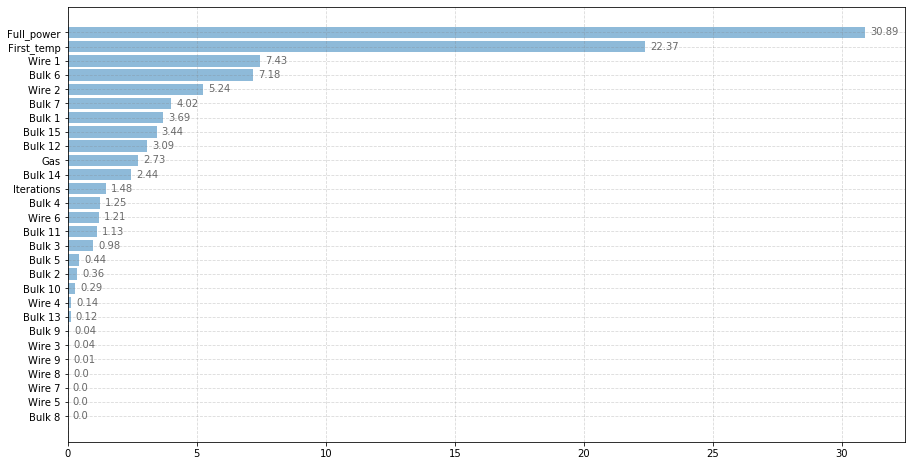

In [ ]:
fig, ax = plt.subplots(figsize =(15, 8))
ax.barh(feature_importance['Feature Id'], feature_importance['Importances'], alpha=0.5)
ax.grid(color='gray', linestyle='dashed', alpha=0.3)
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.2, 
             str(round((i.get_width()), 2)), 
             fontsize = 10, color ='dimgray')

### Results of model training and testing

- Tested 3 models on the training set: CatBoostRegressor, LGBMRegressor, LinearRegressing;
- The CatBoostRegressor model was trained on the selected best hyperparameters;
- Got the final metric MAE = 6.05
- Determined the features + stages that have the greatest impact on the final temperature. With the exception of the characteristics Inlet temperature and Apparent power, the following 3 stages have the greatest influence on the outlet temperature:
     1. Adding wire material 1;
     2. Adding bulk material 14;
     3. Adding bulk material 15.

## Conclusion

<a id="cell3"></a>
**Current problem:**

Build a model that will predict the outlet temperature of the steel. Thus, it is planned to solve the problem of overheating and, accordingly, excessive consumption of electricity.
    
**Result:**

Based on the data received from the client on technological processes and step-by-step measurements of key
characteristics, the CatBoostRegressor model was trained. The mean sum of the absolute difference between the actual value of the final temperature and its predicted value (MAE metric - mean absolute error) was 6.05 (°C).

The stages that have the greatest impact on the outlet temperature are determined. Presumably, they should be paid attention to when further changing the production cycle to reduce power consumption.

**Additional totals:**

In accordance with the approved plan, all tasks were completed.

Difficulties that arose and ways to solve them: correlating signs of power were combined into one according to physical laws; data without a target feature was excluded from the training data set as unsuitable.

Key steps to solving the problem: high-quality data preprocessing, selection of parameters.